In [17]:
import cv2
import numpy as np

def warp_corners_and_draw_matches(ref_points, dst_points, img1, img2):
    # Calculate the Homography matrix
    H, mask = cv2.findHomography(ref_points, dst_points, cv2.USAC_MAGSAC, 3.5, maxIters=1_000, confidence=0.999)
    mask = mask.flatten()

    print('inlier ratio: ', np.sum(mask)/len(mask))

    # Get corners of the first image (image1)
    h, w = img1.shape[:2]
    corners_img1 = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32).reshape(-1, 1, 2)

    # Warp corners to the second image (image2) space
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Draw the warped corners in image2
    img2_with_corners = img2.copy()
    for i in range(len(warped_corners)):
        start_point = tuple(warped_corners[i-1][0].astype(int))
        end_point = tuple(warped_corners[i][0].astype(int))
        cv2.line(img2_with_corners, start_point, end_point, (0, 255, 0), 4)  # Using solid green for corners

    # Prepare keypoints and matches for drawMatches function
    keypoints1 = [cv2.KeyPoint(p[0], p[1], 5) for p in ref_points]
    keypoints2 = [cv2.KeyPoint(p[0], p[1], 5) for p in dst_points]
    matches = [cv2.DMatch(i,i,0) for i in range(len(mask)) if mask[i]]

    # Draw inlier matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2_with_corners, keypoints2, matches, None,
                                  matchColor=(0, 255, 0), flags=2)

    return img_matches


In [15]:
import numpy as np
import imageio as imio
import os
import torch
import tqdm
import cv2
import matplotlib.pyplot as plt

# Inference with batch = 1
# Add current directory to path
import sys
import os
sys.path.append(os.getcwd() + "/../")

from modules.xfeat import XFeat

im1 = np.copy(imio.v2.imread('https://raw.githubusercontent.com/verlab/accelerated_features/main/assets/ref.png')[..., ::-1])
im2 = np.copy(imio.v2.imread('https://raw.githubusercontent.com/verlab/accelerated_features/main/assets/tgt.png')[..., ::-1])

xfeat = XFeat()
top_k = 100

output0 = xfeat.detectAndCompute(im1, top_k = top_k)[0]
output1 = xfeat.detectAndCompute(im2, top_k = top_k)[0]

#Update with image resolution (required)
output0.update({'image_size': (im1.shape[1], im1.shape[0])})
output1.update({'image_size': (im2.shape[1], im2.shape[0])})

loading weights from: /home/raghav/Vilota/xfeat_artifacts/accelerated_features/modules/../weights/xfeat.pt


2025-04-18 14:34:36.237038531 [W:onnxruntime:, graph.cc:4401 CleanUnusedInitializersAndNodeArgs] Removing initializer 'net.token_confidence.3.token.0.bias'. It is not used by any node and should be removed from the model.
2025-04-18 14:34:36.237061607 [W:onnxruntime:, graph.cc:4401 CleanUnusedInitializersAndNodeArgs] Removing initializer 'net.confidence_thresholds'. It is not used by any node and should be removed from the model.
2025-04-18 14:34:36.237064911 [W:onnxruntime:, graph.cc:4401 CleanUnusedInitializersAndNodeArgs] Removing initializer 'net.log_assignment.3.final_proj.weight'. It is not used by any node and should be removed from the model.
2025-04-18 14:34:36.237067337 [W:onnxruntime:, graph.cc:4401 CleanUnusedInitializersAndNodeArgs] Removing initializer 'net.token_confidence.0.token.0.bias'. It is not used by any node and should be removed from the model.
2025-04-18 14:34:36.237073010 [W:onnxruntime:, graph.cc:4401 CleanUnusedInitializersAndNodeArgs] Removing initializer '

Input keypoints0: shape=(1, 100, 2), dtype=float32
Input keypoints1: shape=(1, 100, 2), dtype=float32
Input descriptors0: shape=(1, 100, 64), dtype=float32
Input descriptors1: shape=(1, 100, 64), dtype=float32
Input image_size0: shape=(1, 2), dtype=int32
Input image_size1: shape=(1, 2), dtype=int32
Output 0: name=log_assignment, shape=(1, 101, 101)
Output 1: name=matches0, shape=(1, 100)
Output 2: name=matches1, shape=(1, 100)
Output 3: name=matching_scores0, shape=(1, 100)
Output 4: name=matching_scores1, shape=(1, 100)
inlier ratio:  0.3


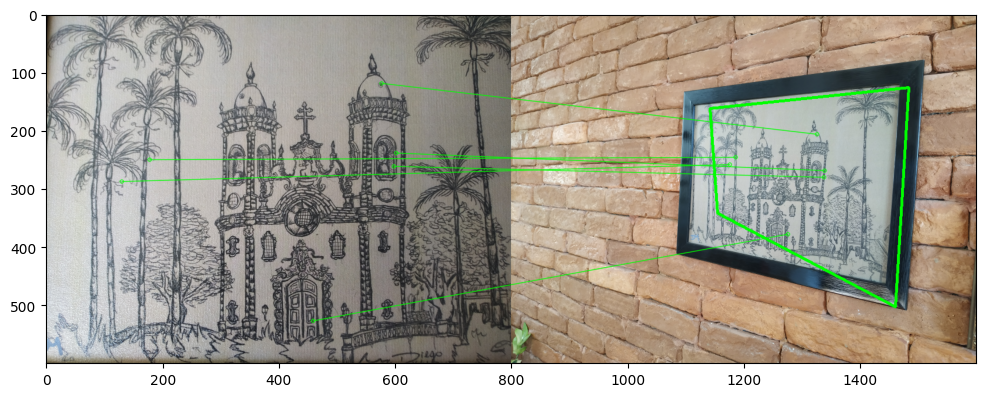

(<matplotlib.image.AxesImage at 0x77991d5ebd90>, None)

In [42]:
import onnxruntime as ort
import torch

# Load model
session = ort.InferenceSession("../onnx_weights/extractor.onnx")

# Inspect input names and shapes
inputs = session.get_inputs()
# for i in inputs:
    # print(f"Input name: {i.name}, shape: {i.shape}, type: {i.type}")

d0 = output0
d1 = output1

input_data = {
        'keypoints0': d0['keypoints'][None, ...][:, :, :2].cpu().numpy(),
        'keypoints1': d1['keypoints'][None, ...][:, :, :2].cpu().numpy(),
        'descriptors0': d0['descriptors'][None, ...].cpu().numpy(),
        'descriptors1': d1['descriptors'][None, ...].cpu().numpy(),
        'image_size0': torch.tensor(d0['image_size'], dtype=torch.int32)[None, ...].cpu().numpy(),
        'image_size1': torch.tensor(d1['image_size'], dtype=torch.int32)[None, ...].cpu().numpy()
}

# Print shape of each input
for name, data in input_data.items():
    print(f"Input {name}: shape={data.shape}, dtype={data.dtype}")

# Run inference
outputs = session.run(None, input_data)  # None returns all output tensors

# Optional: print output names
for i, output in enumerate(session.get_outputs()):
    print(f"Output {i}: name={output.name}, shape={outputs[i].shape}")

# matches, mscores = [], []
# for k in range(1):
#     valid = outputs[1][k] > -1
#     m_indices_0 = np.where(valid)[0]
#     m_indices_1 = outputs[1][k][valid]
#     matches.append(np.stack([m_indices_0, m_indices_1], -1))
#     mscores.append(outputs[-1][k][valid])

# idxs = matches[0]

# mkpts_0 = d0['keypoints'][idxs[:, 0]].cpu().numpy()
# mkpts_1 = d1['keypoints'][idxs[:, 1]].cpu().numpy()


mkpts_0 = []
mkpts_1 = []

for i in range(0, top_k):
    valid0 = outputs[1][0, i] > 0

    if valid0:
        x0 = input_data['keypoints0'][0, i, 0]
        y0 = input_data['keypoints0'][0, i, 1]
        x1 = input_data['keypoints1'][0, outputs[1][0][i], 0]
        y1 = input_data['keypoints1'][0, outputs[1][0][i], 1]

        mkpts_0.append([x0, y0])
        mkpts_1.append([x1, y1])

canvas = warp_corners_and_draw_matches(np.array(mkpts_0), np.array(mkpts_1), im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1]), plt.show()


In [10]:
mkpts_0, mkpts_1, matches = xfeat.match_lighterglue(output0, output1)

print(mkpts_0.shape, mkpts_1.shape)

canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1]), plt.show()

log_assignment: torch.Size([1, 101, 101])
matches0: torch.Size([1, 100])
matches1: torch.Size([1, 100])
matching_scores0: torch.Size([1, 100])
matching_scores1: torch.Size([1, 100])
stop: 6
matches: torch.Size([21, 2])
scores: torch.Size([21])
prune0: torch.Size([1, 100])
prune1: torch.Size([1, 100])


KeyError: 'matches'